In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## BACKGROUND
A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive
maintenance solution to proactively identify when maintenance should be performed. This approach promises cost
savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

## GOAL
You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict
is called failure with binary value 0 for non-failure and 1 for failure.

## DATA
Download link: http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv

Download and read in the dataset

In [2]:
if not os.path.isfile('predictive_maintenance.csv'):
    !wget 'http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv'

In [3]:
df = pd.read_csv('predictive_maintenance.csv', parse_dates =['date'], index_col ='date')
df.head()

,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
date,,,,,,,,,,,
2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


It looks like this is a time series because there is a date column. It looks like there are individual devices that are identified by `device` column. There are 9 `metric` columns.

The task is to predict a failure so lets check and see how the `failure` column is distributed.

In [4]:
df.failure.value_counts()

0    124388
1       106
Name: failure, dtype: int64

This looks like a very imballanced dataset. There are 124,388 nonfailure instanes and 106 failures, which is a failure rate of less than 1%.

Lets see how many unique devices there are and how many of them have failures and how many of them don't have a failure.

In [5]:
total_devices = len(df.device.unique())
print('There are {} total devices'.format(total_devices))

total_failure_devices = len(df[df.failure == 1].device.unique())
print('There are {} total failure devices'.format(total_failure_devices))

There are 1169 total devices
There are 106 total failure devices


It appears that just under 10% of devices have a failure in this data set which is still imbalanced but much less so which viewed this way.

Lets check how the data is distibuted through time.

/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


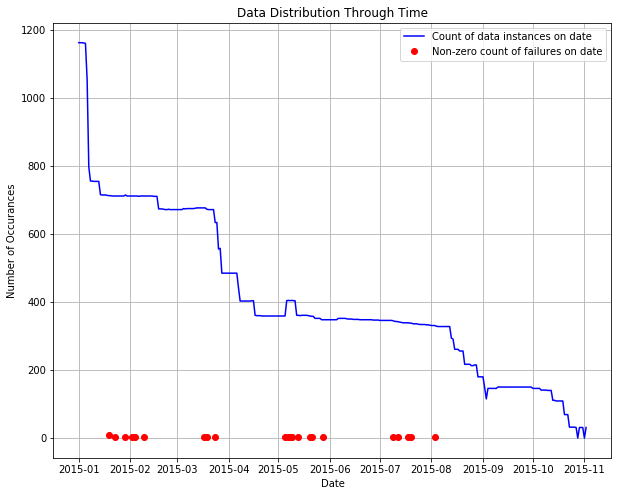

In [6]:
dates = df.failure.resample('D').count().index
values = df.failure.resample('D').count().values
fig, ax = plt.subplots(figsize = (10, 8))
l_counts = ax.plot(dates, values, 'b-', label='Count of data instances on date')

failures = df.failure.resample('D').sum()
failure_dates = failures[failures.values>1].index
failure_values = failures[failures.values>1].values
l_falures = ax.plot(failure_dates, failure_values, 'ro', label='Non-zero count of failures on date')

ax.set_ylabel('Number of Occurances')
ax.set_xlabel('Date')
ax.set_title('Data Distribution Through Time')
ax.grid('on')
_ = ax.legend(loc = 'best')

The data spans less than one year and it is not uniformily distributed through time. It is front loaded. The failures appear to be grouped together but this may or may not be signifigant.

Lets check to see the correlation between variables

In [7]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
failure,1,0.00198348,0.0529016,-0.00094843,0.0673985,0.00226973,-0.000550324,0.119055,0.119055,0.00162157
metric1,0.00198348,1,-0.00424992,0.00370149,0.00183579,-0.00337588,-0.00152197,0.000150676,0.000150676,0.00112075
metric2,0.0529016,-0.00424992,1,-0.00261686,0.146593,-0.0139986,-0.0263496,0.141367,0.141367,-0.00273572
metric3,-0.00094843,0.00370149,-0.00261686,1,0.0974522,-0.0066964,0.00902703,-0.00188394,-0.00188394,0.532366
metric4,0.0673985,0.00183579,0.146593,0.0974522,1,-0.00977282,0.0248699,0.0456309,0.0456309,0.036069
metric5,0.00226973,-0.00337588,-0.0139986,-0.0066964,-0.00977282,1,-0.0170494,-0.00938373,-0.00938373,0.00594942
metric6,-0.000550324,-0.00152197,-0.0263496,0.00902703,0.0248699,-0.0170494,1,-0.0122068,-0.0122068,0.0211525
metric7,0.119055,0.000150676,0.141367,-0.00188394,0.0456309,-0.00938373,-0.0122068,1,1,0.00686067
metric8,0.119055,0.000150676,0.141367,-0.00188394,0.0456309,-0.00938373,-0.0122068,1,1,0.00686067
metric9,0.00162157,0.00112075,-0.00273572,0.532366,0.036069,0.00594942,0.0211525,0.00686067,0.00686067,1


It appears the `metric7` and `metric8` are perfectly correlated with eachother. I will exclude `metric8` from further analysis. None of the variables are particularly well correlated with `failure`. It is interesting that `metric3` and `metric9` have a relatively strong correlation.

In [8]:
df.drop(columns=['metric8'], inplace=True)

## Model Building

Lets try training up some classificaiton models. Because there is such an imbalance in the target variable `failure` some care has to be taken in data split for model training, testing and validation. Also, some thought needs to be put into the correct evaluation metric. Accuracy is the wrong metric because a classifier that predicts no failure every time will have an accuracy above 99%.

In [9]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Different classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

The idea here is to throw a bunch of different classifiers at the problem and see if one works well.

In [10]:
names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "Logistic Regression", "Stochastic Gradient Descent"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    SGDClassifier()]

Split our data into predictor variables `X` and response variable `y`

In [11]:
X = df.filter(regex='metric', axis='columns')
y = df.failure

Here we emply the SMOTE algorithm to oversample the minority class. Oversampling of the minority class is chosen because there are are so few instances of failures. We then also scale the resampled data and then do a test train split.

In [12]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 0)

Now we loop over all over all of our classifiers and check the classification report.

In [13]:
# iterate over classifiers
for name, clf in zip(names, classifiers):
    print(name)
    print('training...')
    clf.fit(X_train, y_train)
    print('predicting...')
    predictions = clf.predict(X_test)
    print('scoring...')
    print(classification_report(y_test, predictions)) 

Nearest Neighbors
training...
predicting...
scoring...
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     37355
           1       0.99      1.00      0.99     37278

    accuracy                           0.99     74633
   macro avg       0.99      0.99      0.99     74633
weighted avg       0.99      0.99      0.99     74633

Decision Tree
training...
predicting...
scoring...
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     37355
           1       0.94      0.94      0.94     37278

    accuracy                           0.94     74633
   macro avg       0.94      0.94      0.94     74633
weighted avg       0.94      0.94      0.94     74633

Random Forest
training...
predicting...
scoring...
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     37355
           1       0.94      0.89      0.91     37278

    accuracy             

/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predicting...
scoring...
              precision    recall  f1-score   support

           0       0.75      0.97      0.85     37355
           1       0.96      0.68      0.80     37278

    accuracy                           0.83     74633
   macro avg       0.86      0.83      0.82     74633
weighted avg       0.86      0.83      0.82     74633

Stochastic Gradient Descent
training...
predicting...
scoring...
              precision    recall  f1-score   support

           0       0.75      0.97      0.85     37355
           1       0.96      0.68      0.79     37278

    accuracy                           0.82     74633
   macro avg       0.85      0.82      0.82     74633
weighted avg       0.85      0.82      0.82     74633



## Can we do better?
The goal of the company is "They would like to create a predictive maintenance solution to proactively identify when maintenance should be performed". The predictive models that were developed above simply say if there has been a failure or not. In reality this likely isn't very useful in a proactive sense, but it was a nice warmup to the problem and to get a general sense of the data set.

Ideally, a solution to this will not just tell that there is a failure, but also _how long_ until the failure will happen so there is time to schedule the neede maintenence. To do this we will engineer another column called `days_to_failure` and build a model to predict this value.

## Days to failure

Now we are going to try and predict the days to failure. This can be viewed as a regression problem instead of a classification problem. Since we are going to predict `days_to_failure` we need to filter our data to devices that have actually had a failure. 

In [14]:
devices = df[df.failure == 1].device.unique()
df_failed_devices = df[df.device.isin(devices)]

Lets check and see how much data we have filtered out.

In [15]:
print('Original data records: {}'.format(len(df)))
print('Failed data records: {}'.format(len(df_failed_devices)))

Original data records: 124494
Failed data records: 10713


Now we add in the feature we are trying to predict with the convencience function

In [16]:
def days_to_failure(df_device):
    '''Computes the number of days till a failure for a given device with an observed failure.
    
    Input:
        df_device: A dataframe with an observed failure
        
    Return:
        to_failure: An array with the number of days to failure
    '''
    fail_date = df_device[df_device.failure == 1].index
    to_failure = []
    for date in df_device.index:
        observation = (fail_date - date).days
        to_failure.append(observation)
    return to_failure

In [17]:
initial_days_to_failure = np.zeros(len(df_failed_devices))
df_failed_devices['days_to_failure'] = initial_days_to_failure
for device in df_failed_devices.device.unique():
    df_device = df_failed_devices[df_failed_devices.device == device]
    device_days_to_failure = days_to_failure(df_device)
    df_failed_devices.loc[df_failed_devices.device == device, ['days_to_failure']] = device_days_to_failure

/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Lets take a look at how this feature turned out

Text(0.5, 0, 'Days to failure')

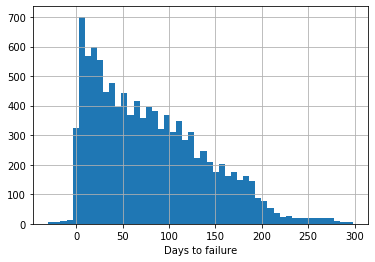

In [18]:
df_failed_devices.days_to_failure.hist(bins=50)
plt.xlabel('Days to failure')

It appears that we have some negative days to failure. That means a failure occured and we still were reported data. Lets drop these records and look again.

Text(0.5, 0, 'Days to failure')

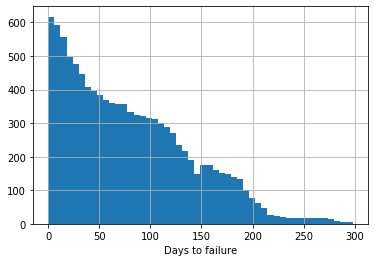

In [19]:
df_failed_devices = df_failed_devices[df_failed_devices.days_to_failure >= 0]
df_failed_devices.days_to_failure.hist(bins=50)
plt.xlabel('Days to failure')

This looks better. Lets see if we can build a regression model that will predict the remaining life of a device. For this task we will use RMSE as our evaluation metric. RMSE is interpretable and is sensitive to outliers. It is interpretable because it is on the same scale as the original data. The sensativity to outliers means that just one very bad prediction will result in a much higher RMSE, this is a good property to have because we want all of our predictions to be as close to reality as possible.

In [20]:
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

names = ["Linear Regression", "SVM", "KNN", "Gaussian Process", "Decision Tree",
         "Random Forrest", "AdaBoost", "Gradient Boosting", "Neural Net"]

regressors = [
    LinearRegression(),
    SVR(),
    KNeighborsRegressor(),
    GaussianProcessRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),
    GradientBoostingRegressor(max_depth=None),
    MLPRegressor(max_iter=1000)
]

Here we do our test, train split and then test out each model type. Since we are using RMSE for our evaluation metric, we first print out the standard deviation of the data. This is a baseline benchmark. If we predicted the average days to failure and then measured the RMSE then we would get the standard deviation. We aim to do better than this.

In [21]:
X = df_failed_devices.filter(regex='metric', axis='columns')
y = df_failed_devices.days_to_failure

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Standard Deviation: {}\n'.format(np.std(y_test)))

for name, rgr in zip(names, regressors):
    print(name)
    print('training...')
    rgr.fit(X_train, y_train)
    print('predicting...')
    predictions = rgr.predict(X_test)
    print('RMSE: {}\n'.format(np.sqrt(mean_squared_error(y_test, predictions))))

Standard Deviation: 60.79494247763844

Linear Regression
training...
predicting...
RMSE: 59.58752185387237

SVM
training...
predicting...
RMSE: 57.10223668127305

KNN
training...
predicting...
RMSE: 49.59407147028766

Gaussian Process
training...
predicting...
RMSE: 5901.997847362485

Decision Tree
training...
predicting...
RMSE: 25.95414827151914

Random Forrest
training...
predicting...


/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE: 22.552527782379517

AdaBoost
training...
predicting...
RMSE: 25.36819490030775

Gradient Boosting
training...
predicting...
RMSE: 25.835114324846188

Neural Net
training...
predicting...
RMSE: 52.480832044508304



/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


It appears that the Random Forrest model is the best out of the box. Lets do some hyperparameter tuning to see if we can make it better.

In [22]:
from sklearn.model_selection import RandomizedSearchCV

Now we set up the random grid search space and run the experiment.

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 3, 
    verbose=2, 
    random_state=42, 
    n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   54.3s


In [ ]:
predictions = rf_random.best_estimator_.predict(X_test)
print('RMSE: {}\n'.format(np.sqrt(mean_squared_error(y_test, predictions))))

So after some hyper parameter tuning, we reduced the RMSE from 22.5 to 21.5, this can be intepreted as the average error has been reduced by a day which is not bad. Now lets see how the residuals are distributed.

In [ ]:
residuals = predictions - y_test
five_percent = np.percentile(residuals, 5)
median = np.percentile(residuals, 50)
ninty_five_percent = np.percentile(residuals, 95)

print(five_percent, ninty_five_percent)

x = np.arange(0, 300, 1)
y_ninety_five = x + ninty_five_percent
y_median = x + median
y_five = x[25:] + five_percent

fig, ax = plt.subplots(figsize = (10, 8))
ax.scatter(y_test, predictions)
ax.plot(x, y_median, 'k:', label='median')
ax.plot(x, y_ninety_five, 'r--', label='95th Percentile')
ax.plot(x[25:], y_five, 'r--', label='5th Percentile')

ax.set_xlabel('Actual Time to Failure')
ax.set_ylabel('Predicted Time to Failure')
ax.set_title('Residual Time to Failures')
ax.grid('on')
ax.legend()

The final model is able to predict 90% of failures within a 52 day window. This is the area between the red dotted lines seen above. This may or may not be adequate for the companies purposes but it does allow for some proactive maintenence to be scheduled based on sensor readings and this model. 

## Model in Practice

To put it into practice we can say that any say that any device that is predicted to fail within N days will be scheduled for maintenence. Let us see how it performs on the non-failed devices. For a concrete example we will look for devices that are predicted to fail in the next 15 days.

We filter down to our un-failed devices and then scale the sensor data to prepare it for prediction and then pass it through our best estimator.

In [ ]:
failed_devices = df[df.failure == 1].device.unique()
all_devices = df.device.unique()
unfailed_devices = [device for device in all_devices if device not in failed_devices]
df_unfailed = df[df.device.isin(unfailed_devices)]
X_unfailed = scaler.transform(df_unfailed.filter(regex='metric'))
unfailed_predictions = rf_random.best_estimator_.predict(X_unfailed)
df_unfailed['predicted_days_to_fail'] = unfailed_predictions

Lets check the distribution of predicted days to failure.

In [ ]:
df_unfailed.predicted_days_to_fail.hist(bins=50)
plt.xlabel('Predicted Days to Failure')

Lets check to see how many unfailed devices there are and compare it with the number of devices that we have predicted to fail within the next 15 days.

In [ ]:
EXPECTED_FAIL_DAYS = 15
num_unfailed_devices = len(df_unfailed.device.unique())
num_predicted_to_fail = len(df_unfailed[df_unfailed.predicted_days_to_fail <= EXPECTED_FAIL_DAYS].device.unique())
print('There are {} unfailed devices, we expect {} to fail in {} days.'.format(num_unfailed_devices, num_predicted_to_fail, EXPECTED_FAIL_DAYS))

Now lets see how these devices that are expected to fail in the next 15 days are distributed through time.

In [ ]:
expected_failures = {}
for device in unfailed_devices:
    df_device_unfailed = df_unfailed[df_unfailed.device == device]
    df_expected_fail = df_device_unfailed[df_device_unfailed.predicted_days_to_fail <= EXPECTED_FAIL_DAYS]
    if len(df_expected_fail): # Check to see if these device is expected to fail in our timeframe
        expected_fail_date = df_expected_fail.index.min()
        if expected_fail_date in expected_failures.keys():
            expected_failures[expected_fail_date] += 1
        else:
            expected_failures[expected_fail_date] = 1

In [ ]:
dates = df_unfailed.predicted_days_to_fail.resample('D').count().index
values = df_unfailed.predicted_days_to_fail.resample('D').count().values

fig, ax = plt.subplots(figsize = (10, 8))

l_counts = ax.plot(dates, values, 'b-', label='Count of Unfailed instances on date')

lists = sorted(expected_failures.items()) 
dates_fails, num_expected_fails = zip(*lists) 
l_falures = ax.plot(dates_fails, num_expected_fails, 'ro', label='Expected Failure in {} Days'.format(EXPECTED_FAIL_DAYS))

ax.set_ylabel('Number of Occurances')
ax.set_xlabel('Date')
ax.set_title('Predicted Failures in {} Days Distribution Through Time'.format(EXPECTED_FAIL_DAYS))
ax.grid('on')
_ = ax.legend(loc = 'best')

## Final thoughts

This was a first pass at a predictive maintenence solution. It seems to have worked in the sense that this model gave guidance to how long a device had until a failure based on the different metrics. The model was working much better than simply predicting the average time to failure.

This is just one method to attempt to solve this problem. Other methods could be to employ survival analysis in the form of a Cox Regression. Also some kind of RNN could have been developed to see if it performed better than the classical machine learning methods that were employed. The solution to a data science problem can always be improved in any number of ways.